# Invoices Misalignment Correction

In the given problem statement, we are tasked with correcting the alignments of invoices, whose texts are not aligned with the vertical and horizontal axes.

So for the given task, we will employ couple of image processing techniques combined with some OCR techniques to find the appropriate angle of rotation.

## Explanation of the approach

1) Firstly, we will try do some preprocessing in the images, so as to make the text as white, and all the background as black, because our region of interest would be the text region.

2) Now, we will try to identify the bouding box for each of the text regions using the OCR tool.

3) After getting the bounding box for each text region, we will isolate that block, and using the function cv2.minAreaRect, we will try to find the misalignment of this textual region with respect to the horizontal and vertical axes. 

4) We will repeat the above step for all of the text region, so as to find the average/median anlge of rotation.

5) Since the above method only checks for the alignment of the rectangle enclosing the area of interest, it so might happen that the text might be aligned parallel to the vertical axes, instead of the horizontal axes from the above step. So, to rectify that, we use the pytesseract's orientation detection, to correct the orientation.

## Installing required libraries and packages

In [ ]:
!pip install pytesseract
!sudo apt update
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev

## Importing important libraries

In [1]:
# import the necessary packages
import pandas as pd
import numpy as np

import os
import re
import cv2
import pytesseract
from statistics import median
from pytesseract import Output
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

## Invoice misalignment correction code

In [14]:
class image_alignment_correction:

    def __init__(self):
        pass

    def img_preprocessing(self, img):
        #converting the image to grayscale
        grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #also inverting the image, so as to make text white, and background black
        grayscale_img = cv2.bitwise_not(grayscale_img)

        #thresholding the image
        thresh = cv2.threshold(grayscale_img, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

        return thresh

    def rotation_angles_detection(self, threshold_img):
        #setting the config for the ocr
        custom_config = r'-l eng --oem 3 --psm 1'
        #getting the text data from the image
        d = pytesseract.image_to_data(threshold_img, config=custom_config, output_type=Output.DICT)
        data = pd.DataFrame(d)
        #filtering the data without text
        data = data[(data.conf!=-1) & (data.text != '') & (data.text != ' ')]
        angles = []
        #iterating through all the text blocks
        for index, row in data.iterrows():
                if row.conf > 20:
                    x1, y1, h, w = row[['left', 'top', 'height','width']]
                    #localizing only the given text blocks
                    thresh_temp = threshold_img[y1 : y1 + h, x1 : x1 + w]

                    coords = np.stack(np.where(thresh_temp > 0), axis = -1)
                    #getting the angle of rotation for the given block
                    angle = cv2.minAreaRect(coords)[-1]
                    if angle < -45:
                        angle = -(90 + angle)
                        # otherwise, just take the inverse of the angle to make
                        # it positive
                    else:
                        angle = -angle
                    #appending to the list of angles
                    angles.append(angle)

        #now finding the median for the angle of rotation
        angles_non_zero = [ele for ele in angles if ele!= 0.0]

        if len(angles_non_zero) / len(angles) > 0.3:
            angle_of_rotation = median(angles_non_zero)
        else:
            angle_of_rotation = median(angles)

        return angle_of_rotation

    def rotate_img(self, img, angle_of_rotation):
        #now rotating the image
        h, w = img.shape[:2]
        center = (w // 2, h // 2)
        rotn_matrix = cv2.getRotationMatrix2D(center, angle_of_rotation, 1.0)
        rotated_img = cv2.warpAffine(img, rotn_matrix, (w, h), 
                                flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        
        return rotated_img

    def overall_rotation_correction_text(self, img):
        #also correcting the overall rotation of the image
        try:
            orientation_details = pytesseract.image_to_osd(img)
            rotation_angle = int(re.search(r'Rotate: (\d+)', orientation_details).group(1))
        except:
            rotation_angle = 0


        rot = None
        if rotation_angle == 0:
            pass
        elif rotation_angle == 90:
            rot = cv2.ROTATE_90_CLOCKWISE
        elif rotation_angle == 270:
            rot = cv2.ROTATE_90_COUNTERCLOCKWISE
        elif rotation_angle == 180:
            rot = cv2.ROTATE_180
        if rot is not None: 
            img = cv2.rotate(img, rot)
        
        return img

    def process_img(self, img_path, save_dir = '', save_img = False):
        #loading the image first
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #preprocessing the image
        thresholded_img = self.img_preprocessing(img)
        #getting rotation angle
        angle_of_rotation = self.rotation_angles_detection(thresholded_img)
        #rotating the image
        img = self.rotate_img(img, angle_of_rotation)
        #final correction
        img = self.overall_rotation_correction_text(img)
        #checking for correction again
        img = self.overall_rotation_correction_text(img)

        if save_img == True:
            save_path = os.path.join(save_dir, img_path.split('/')[-1])
            cv2.imwrite(save_path, img)

        return img

In [15]:
def plot_samples(img_path, aligner):
    #loading the image
    original_image = cv2.imread(img_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    aligned_img = aligner.process_img(img_path)

    plt.figure(figsize = (20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Misaligned Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(aligned_img)
    plt.title('Alignment Corrected Image')
    plt.axis('off')

    plt.show()

## Sample outputs

In [16]:
#instantiating the object of the class for alignment correction
aligner = image_alignment_correction()

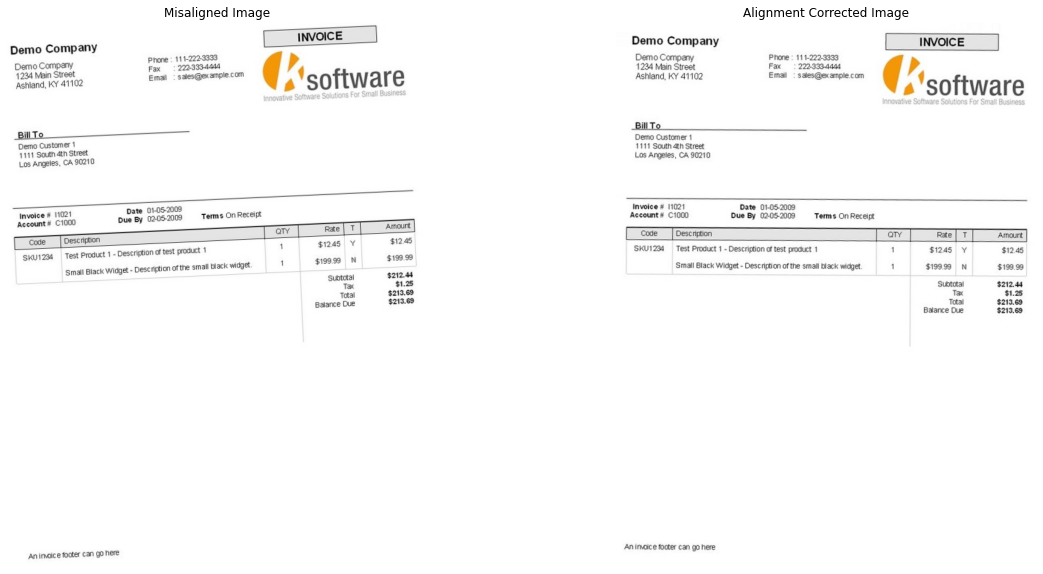

In [17]:
plot_samples('misaligned_images/0f97914844b786b0d2ef21339286cdf6 - 2.jpg', aligner)

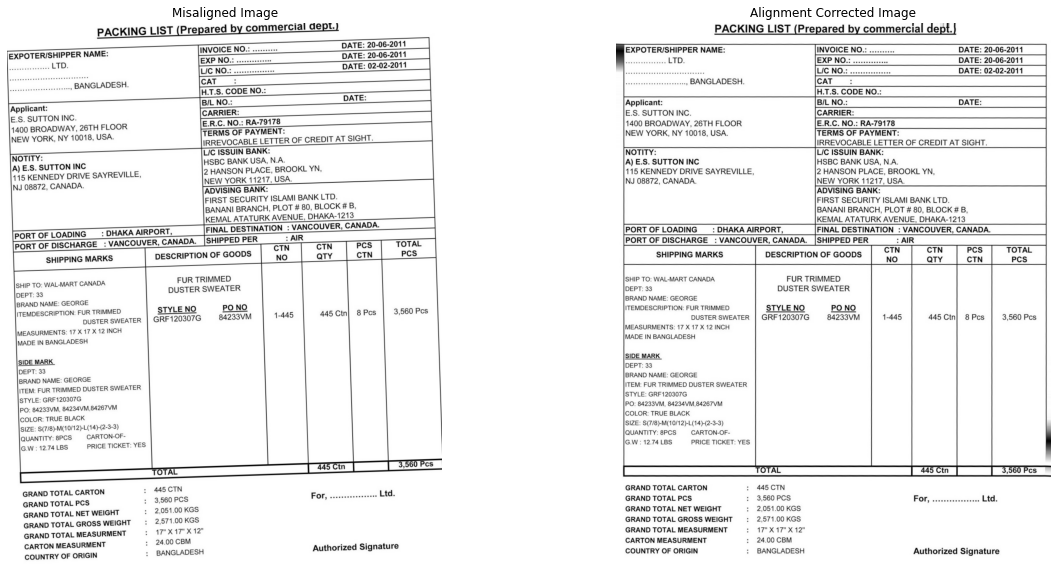

In [8]:
plot_samples('misaligned_images/5.jpg', aligner)

## Aligning all the images

In [7]:
for ele in os.listdir('misaligned_images'):
    _ = aligner.process_img(img_path = f'misaligned_images/{ele}', save_dir = 'aligned_images', save_img = True)